# Load date & data augmentation

In [2]:
from tensorflow.keras.utils import image_dataset_from_directory
image_size = (256, 256)
train_ds, val_ds = image_dataset_from_directory(
    "/kaggle/input/real-and-fake-face-detection/real_and_fake_face",
    validation_split=0.2,
    subset="both",
    label_mode = "categorical",
    seed=123,
    batch_size = 32,
    image_size=image_size)

Found 2041 files belonging to 2 classes.
Using 1633 files for training.
Using 408 files for validation.


In [4]:
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#data_gen = ImageDataGenerator(horizontal_flip=True,
#                              vertical_flip=False)
#train_ds_augmented= train_ds.map(lambda X, y: (data_gen.flow(X, batch_size = 32), y))

NotImplementedError: in user code:

    File "/tmp/ipykernel_28/3721593656.py", line 5, in None  *
        lambda X, y: (data_gen.flow(X, batch_size = 32), y)
    File "/opt/conda/lib/python3.10/site-packages/keras/preprocessing/image.py", line 1545, in flow  **
        return NumpyArrayIterator(
    File "/opt/conda/lib/python3.10/site-packages/keras/preprocessing/image.py", line 755, in __init__
        self.x = np.asarray(x, dtype=self.dtype)

    NotImplementedError: Cannot convert a symbolic tf.Tensor (args_0:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.


In [5]:
#type(train_ds.unbatch())

tensorflow.python.data.ops.unbatch_op._UnbatchDataset

# CNN base model

In [4]:
from tensorflow.keras.metrics import Recall, Precision

metrics = [
    Recall(name='recall'),
    Precision(name='precision'),
    'accuracy']

In [9]:
from tensorflow.keras import models, Sequential, layers, regularizers
from tensorflow.keras.losses import CategoricalCrossentropy

model = models.Sequential([
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.25),
    layers.RandomContrast(0.2)
])
model.add(layers.Input(shape=(image_size[0],image_size[1],3)))

model.add(layers.Rescaling(1/255))
model.add(layers.Conv2D(8, kernel_size = (4,4), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(16, kernel_size = (3,3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(32, kernel_size = (2,2), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(rate=0.2))  
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(rate=0.2))  
model.add(layers.Dense(2, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=metrics)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
es = EarlyStopping(patience = 5, 
                   restore_best_weights = True,
                   monitor = 'val_loss')

mcp = ModelCheckpoint("{}.h5".format('base_model'),
                      save_weights_only=True,
                      monitor='val_loss',
                      mode='min',
                      verbose=0,
                      save_best_only=True)

history = model.fit(train_ds,
          validation_data = val_ds,
          batch_size = 32,
          epochs = 20,
          callbacks = [es,mcp])


Epoch 1/20
52/52 [==============================] - 38s 344ms/step - loss: 0.7039 - recall: 0.5028 - precision: 0.5028 - accuracy: 0.5028 - val_loss: 0.6928 - val_recall: 0.5147 - val_precision: 0.5147 - val_accuracy: 0.5147
Epoch 2/20
52/52 [==============================] - 15s 254ms/step - loss: 0.6918 - recall: 0.5321 - precision: 0.5321 - accuracy: 0.5321 - val_loss: 0.6926 - val_recall: 0.5147 - val_precision: 0.5147 - val_accuracy: 0.5147
Epoch 3/20
52/52 [==============================] - 14s 235ms/step - loss: 0.6902 - recall: 0.5334 - precision: 0.5334 - accuracy: 0.5334 - val_loss: 0.6921 - val_recall: 0.5147 - val_precision: 0.5147 - val_accuracy: 0.5147
Epoch 4/20
52/52 [==============================] - 16s 282ms/step - loss: 0.6921 - recall: 0.5334 - precision: 0.5334 - accuracy: 0.5334 - val_loss: 0.6909 - val_recall: 0.5147 - val_precision: 0.5147 - val_accuracy: 0.5147
Epoch 5/20
52/52 [==============================] - 17s 301ms/step - loss: 0.6904 - recall: 0.5315 -

In [3]:
import matplotlib.pyplot as plt
def plot_loss_precision_recall_curve(history):
    
    fig, ax =plt.subplots(1,3,figsize=(20,5))
    
    # --- LOSS
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'], loc='upper right')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- RECALL
    ax[1].plot(history.history['recall'])
    ax[1].plot(history.history['val_recall'])
    ax[1].set_title('Model recall', fontsize = 18)
    ax[1].set_xlabel('Epoch', fontsize = 14)
    ax[1].set_ylabel('Recall', fontsize = 14)
    ax[1].legend(['Train', 'Val'], loc='lower right') 
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    # --- PRECISION
    
    
    ax[2].plot(history.history['precision'])
    ax[2].plot(history.history['val_precision'])
    ax[2].set_title('Model precision', fontsize = 18)
    ax[2].set_xlabel('Epoch', fontsize = 14)
    ax[2].set_ylabel('Precision', fontsize = 14)
    ax[2].legend(['Train', 'Val'], loc='lower right')  
    ax[2].grid(axis="x",linewidth=0.5)
    ax[2].grid(axis="y",linewidth=0.5)    
    
    plt.show()


In [ ]:
plot_loss_precision_recall_curve(history)

In [ ]:
model.evaluate(val_ds)

#  CNN transfer learning

## VGG16(trained on ImageNet)

In [4]:
from tensorflow.keras.applications.vgg16 import VGG16
VGG16 = VGG16(
    weights='imagenet',
    input_shape=(image_size[0],image_size[1], 3),
    include_top=False)
VGG16.trainable = True

from tensorflow.keras import models, Sequential, layers, regularizers
from tensorflow.keras.losses import CategoricalCrossentropy

VGG16 = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomZoom(height_factor=(-0.5,-0.8),width_factor=(-0.5,-0.8),fill_mode='constant'),
    layers.RandomRotation(factor=(-0,5,0.5), fill_mode='constant'),
    layers.RandomContrast(factor=(0.2,0.8)),
    VGG16,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(2, activation='softmax')
])
from tensorflow.keras.applications.vgg16 import preprocess_input
train_ds_preprocessed= train_ds.map(lambda X, y: (preprocess_input(X), y))
val_ds_preprocessed= val_ds.map(lambda X, y: (preprocess_input(X), y))

58889256/58889256 [==============================] - 2s 0us/step


In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
es = EarlyStopping(patience = 5, 
                   restore_best_weights = True,
                   monitor = 'val_loss')

mcp = ModelCheckpoint("{}.h5".format('VGG_model'),
                      save_weights_only=True,
                      monitor='val_loss',
                      mode='min',
                      verbose=1,
                      save_best_only=True)
rlr = ReduceLROnPlateau(monitor='val_loss',
                        factor=0.1,
                        patience=3,
                        verbose=1,
                        min_delta=0.0001,
                        cooldown=0,
                        min_lr=0)

from tensorflow.keras.metrics import Recall, Precision
metrics = [
    Recall(name='recall'),
    Precision(name='precision'),
    'accuracy']

from tensorflow.keras.optimizers import Adam
VGG16.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=metrics)
hist_vgg16 = VGG16.fit(train_ds_preprocessed,
          validation_data = val_ds_preprocessed,
          batch_size = 32,
          epochs = 20,
          callbacks = [es,mcp,rlr])

Epoch 1/20
52/52 [==============================] - ETA: 0s - loss: 1.3290 - recall: 0.5181 - precision: 0.5181 - accuracy: 0.5181
Epoch 1: val_loss improved from inf to 0.69279, saving model to VGG_model.h5
52/52 [==============================] - 52s 552ms/step - loss: 1.3290 - recall: 0.5181 - precision: 0.5181 - accuracy: 0.5181 - val_loss: 0.6928 - val_recall: 0.5147 - val_precision: 0.5147 - val_accuracy: 0.5147 - lr: 0.0010
Epoch 2/20
51/52 [============================>.] - ETA: 0s - loss: 0.6914 - recall: 0.5288 - precision: 0.5288 - accuracy: 0.5288
Epoch 2: val_loss did not improve from 0.69279
52/52 [==============================] - 24s 421ms/step - loss: 683598.7500 - recall: 0.5291 - precision: 0.5291 - accuracy: 0.5291 - val_loss: 0.6929 - val_recall: 0.5147 - val_precision: 0.5147 - val_accuracy: 0.5147 - lr: 0.0010
Epoch 3/20
51/52 [============================>.] - ETA: 0s - loss: 69391.4766 - recall: 0.5067 - precision: 0.5067 - accuracy: 0.5067
Epoch 3: val_loss di

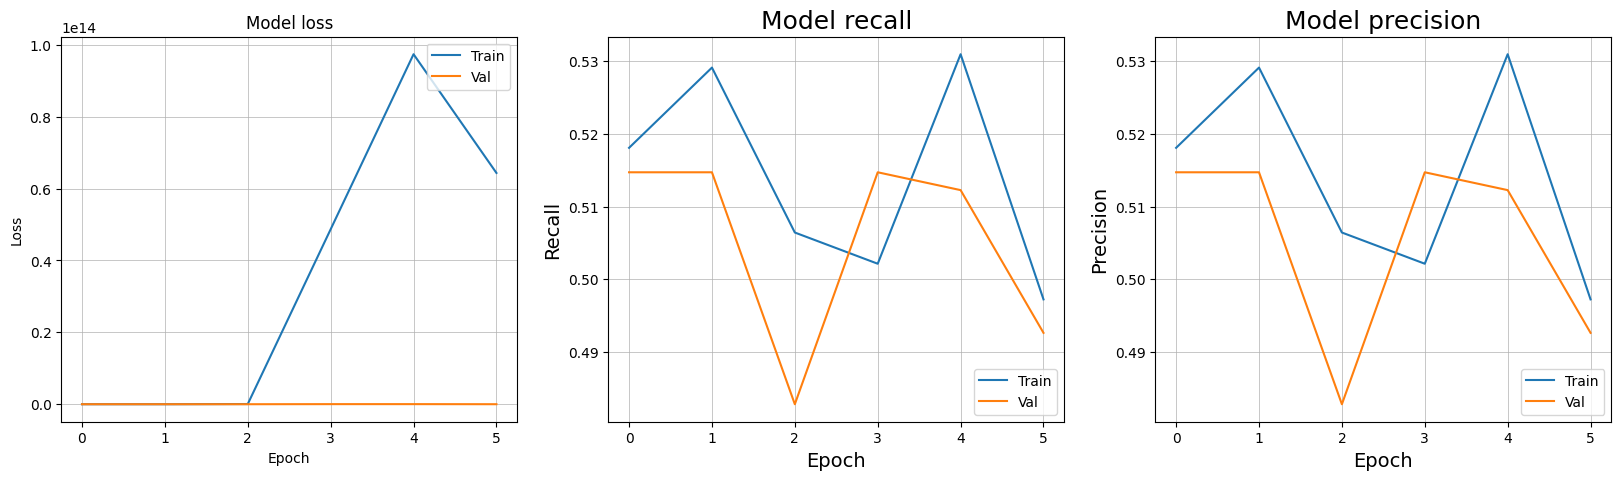

In [6]:
plot_loss_precision_recall_curve(hist_vgg16)

## InceptionV3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
InceptionV3 = InceptionV3(
    weights='imagenet',
    input_shape=(image_size[0],image_size[1], 3),
    include_top=False)

InceptionV3.trainable = False
InceptionV3 = Sequential([
    InceptionV3,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(2, activation='softmax')
])

from tensorflow.keras.applications.inception_v3 import preprocess_input
train_ds_preprocessed= train_ds.map(lambda X, y: (preprocess_input(X), y))
val_ds_preprocessed= val_ds.map(lambda X, y: (preprocess_input(X), y))

In [ ]:
mcp = ModelCheckpoint("{}.h5".format('InceptiveV3_model'),
                      save_weights_only=True,
                      monitor='val_loss',
                      mode='min',
                      verbose=0,
                      save_best_only=True)

from tensorflow.keras.optimizers import Adam
InceptionV3.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=metrics)

hist_InceptionV3 = InceptionV3.fit(train_ds_preprocessed,
          validation_data = val_ds_preprocessed,
          batch_size = 32,
          epochs = 20,
          callbacks = [es,mcp])

In [ ]:
plot_loss_precision_recall_curve(hist_InceptionV3)

## ResNet50

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
ResNet50 = ResNet50(
    weights='imagenet',
    input_shape=(image_size[0],image_size[1], 3),
    include_top=False)

from tensorflow.keras import models, Sequential, layers, regularizers
from tensorflow.keras.losses import CategoricalCrossentropy
ResNet50.trainable = False
ResNet50 = Sequential([
    ResNet50,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(2, activation='softmax')
])
from tensorflow.keras.applications.resnet50 import preprocess_input
train_ds_preprocessed= train_ds.map(lambda X, y: (preprocess_input(X), y))
val_ds_preprocessed= val_ds.map(lambda X, y: (preprocess_input(X), y))

In [ ]:
mcp = ModelCheckpoint("{}.h5".format('ResNet50_model'),
                      save_weights_only=True,
                      monitor='val_loss',
                      mode='min',
                      verbose=0,
                      save_best_only=True)

from tensorflow.keras.optimizers import Adam
ResNet50.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=metrics)

hist_ResNet50 = ResNet50.fit(train_ds_preprocessed,
          validation_data = val_ds_preprocessed,
          batch_size = 32,
          epochs = 20,
          callbacks = [es,mcp])

In [ ]:
plot_loss_precision_recall_curve(hist_ResNet50)